In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time

from library.evaluation import ConfusionMatrix

dataset_name = "Phemernr1_wF_cconv-RNR"
unique_name = "RoBERTa_Finetuned"

In [2]:
vectors = np.loadtxt("../../data/processed/vectors/Phemernr1-RNR_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
first = vectors[0]
vectors.shape

(5802, 768)

In [3]:
data = pd.read_csv("../../data/processed/phemernr1_dataset_with_tvt.csv", lineterminator="\n")
data.head()

,tweet_text,topic,label,tvt,cv_fold,tvt2
0,BOMBSHELL: #Ferguson chief says the police off...,ferguson,rumours,test,3,validation
1,It appears that #Ferguson PD are trying to ass...,ferguson,rumours,training,1,training
2,"All weekend ppl will be talking about the ""rob...",ferguson,rumours,test,3,training
3,Why would the officer tell #MikeBrown to get o...,ferguson,rumours,test,3,validation
4,Michael Brown is the 17 yr old boy who was sho...,ferguson,rumours,training,0,training


In [4]:
data_features = np.loadtxt("../../data/processed/vectors/phemernr1_dataset_features_vectors.csv", delimiter=",")
print(data_features.shape)

data_features = np.delete(data_features, [10,29,33], axis=1)
print(data_features.shape)

f_vectors =  data_features.reshape((5802,1,6,6))
print(f_vectors.shape)

(5802, 39)
(5802, 36)
(5802, 1, 6, 6)


In [5]:
labels_str = ['rumour', 'non-rumour']
labels_str

['rumour', 'non-rumour']

In [6]:
labels = []
for i, d in data.iterrows():
#     lab = labels_str.index(d['label'])
    if d['label'] == "rumours":
        lab = 0
    else:
        lab = 1
    labels.append(lab)
labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [7]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_feats = np.array([f_vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_feats = np.array([f_vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_feats = np.array([f_vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [8]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_feats.shape)
print(val_feats.shape)
print(test_feats.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(3841, 768)
(1350, 768)
(611, 768)
(3841, 1, 6, 6)
(1350, 1, 6, 6)
(611, 1, 6, 6)
(3841,)
(1350,)
(611,)


In [9]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class CustomCNN(nn.Module):
    
    def __init__(
        self,
        n_input: int,
        n_output: int
    ):
        super(CustomCNN, self).__init__()
        self.feature_conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
        )
        self.classification = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, n_output),
        )


class CNNClassifier(nn.Module):
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        n_features: int = 4,
        lr: float = 0.0002,
        beta1: float = 0.5,
        device: str = None
    ):
        super(CNNClassifier, self).__init__()
        self.model = CustomCNN(n_input, n_output)
        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
#         if self.device == 'cuda':
#             self.model = torch.nn.DataParallel(self.model)
#             cudnn.benchmark = True

    def forward(self, input):
        x = self.model(input)
        return x
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/{saves}.pth")
    
    def train_eval(self,
        train_vec, train_x, train_y,
        test_vec, test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None
    ):
        trainset = torch.utils.data.TensorDataset(train_vec, train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_vec, test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (vectors, inputs, targets) in enumerate(trainloader):
                self.model.zero_grad()
                vectors, inputs, targets = vectors.to(self.device), inputs.to(self.device), targets.to(self.device)

                feature_tensor = self.model.feature_conv(inputs)
                inputs2 = torch.cat((vectors, feature_tensor), 1)
                outputs = self.model.classification(inputs2)

                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                total += targets.size(0)

            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            with torch.no_grad():
                vectors, inputs, targets = test_vec.to(self.device), test_x.to(self.device), test_y.to(self.device)

                feature_tensor = self.model.feature_conv(inputs)
                inputs2 = torch.cat((vectors, feature_tensor), 1)
                outputs = self.model.classification(inputs2)

                loss = self.criterion(outputs, targets.long())
                test_loss += loss.item()
                
                preds = self.predict(vectors, inputs)
                conf_mat = ConfusionMatrix(
                    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_y]),
                    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()]),
                    binary=False
                )
                conf_mat.evaluate(logs=False)
                test_acc = conf_mat.accuracy

            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break

        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax2.plot([i for i in range(len(train_losses))], train_losses, c='b', marker="o", label='Train Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, c='r', marker="o", label='Test Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_xlim(0, len(train_losses))
        ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Loss over time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
    
    def predict(self, input_vec, input_x):
        self.model.eval()
        with torch.no_grad():
            feature_tensor = self.model.feature_conv(input_x)
            inputs2 = torch.cat((input_vec, feature_tensor), 1)
            preds = self.model.classification(inputs2)

            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

Multiclass Classification Phemernr1_wF_cconv-RNR_ResNet10_CNN_RoBERTa_Finetuned
Using cuda
Saving after new best accuracy : 86.741
Saving after new best accuracy : 86.815
Saving after new best accuracy : 86.889
-- Epoch 50, Train Loss : 0.48266779631376266, Test Loss : 0.3852443993091583
-- Epoch 100, Train Loss : 0.4736483618617058, Test Loss : 0.3784880042076111
-- Epoch 150, Train Loss : 0.4613258019089699, Test Loss : 0.3755088746547699
Saving after new best accuracy : 86.963
-- Epoch 200, Train Loss : 0.4381295442581177, Test Loss : 0.38012710213661194
Saving after new best accuracy : 87.037
Saving after new best accuracy : 87.111
-- Epoch 250, Train Loss : 0.41038764268159866, Test Loss : 0.4331458508968353
-- Epoch 300, Train Loss : 0.3927191272377968, Test Loss : 0.4084600508213043
Saving after new best accuracy : 87.185
-- Epoch 350, Train Loss : 0.36844107508659363, Test Loss : 0.49802306294441223
-- Epoch 400, Train Loss : 0.3584335297346115, Test Loss : 0.5001384615898132
-

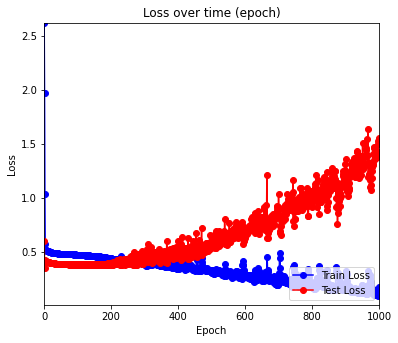

Exec Time : 88.27 seconds

---- Validation Set ----
Predictions : torch.Size([1350])
1350 vs 1350
Multi Class Evaluation

Class rumour Evaluation
- Precision : 80.13 %
- Recall : 82.262 %
- F1 : 0.81182

Class non-rumour Evaluation
- Precision : 90.981 %
- Recall : 89.766 %
- F1 : 0.9037

Combined Evaluation
- Accuracy : 87.259 %
- Precision : 85.555 %
- Recall : 86.014 %
- F1 : 0.85784

- Average Confidence : 100.0 %
Model, Combined,,,,rumour,,,non-rumour,,,
Phemernr1_wF_cconv-RNR_ResNet10_CNN_RoBERTa_Finetuned Validation, 87.259, 85.555, 86.014, 0.85784, 80.13, 82.262, 0.81182, 90.981, 89.766, 0.9037, 

---- Test Set ----
Predictions : torch.Size([611])
611 vs 611
Multi Class Evaluation

Class rumour Evaluation
- Precision : 81.463 %
- Recall : 80.288 %
- F1 : 0.80872

Class non-rumour Evaluation
- Precision : 89.901 %
- Recall : 90.571 %
- F1 : 0.90235

Combined Evaluation
- Accuracy : 87.07 %
- Precision : 85.682 %
- Recall : 85.43 %
- F1 : 0.85556

- Average Confidence : 100.0 %
M

In [10]:
model_name = f"{dataset_name}_ResNet10_CNN_{unique_name}"
start = time.time()
print(f"Multiclass Classification {model_name}")
model = CNNClassifier(train_vectors.shape[1] + 256, n_output=2, criterion=nn.CrossEntropyLoss) #, device="cpu")
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_feats),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors),
                torch.Tensor(val_feats),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=1024)

print(f"Exec Time : {round(time.time() - start, 2)} seconds")

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\n---- Validation Set ----")
preds = model.predict(torch.Tensor(val_vectors).to('cuda'), torch.Tensor(val_feats).to('cuda'))
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in val_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Validation"
)
conf_mat.evaluate(classes=labels_str)

print("\n---- Test Set ----")
preds = model.predict(torch.Tensor(test_vectors).to('cuda'), torch.Tensor(test_feats).to('cuda'))
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Test"
)
conf_mat.evaluate(classes=labels_str)